Generar gráficos para la Buck en CCM

In [ ]:
import ltspice
import numpy as np
import matplotlib.pyplot as plt

# Load the signals from the .raw file
raw_file = 'Simulacion SPICE - Montecarlo Completo.raw'
l = ltspice.Ltspice(raw_file) 
# Make sure that the .raw file is located in the correct path
l.parse() 

#Parameters for the circuit
Vd_param = 12
D = 0.4
Vo_param = Vd_param*D
Fs = 100E3
Ts = 1/Fs

L = 40E-6
C = 15E-6
R = 5

#How many periods we want?
N_periods = 1.2

#Obtain basic signals

time = l.get_time()
time = (time - 1E-3)*1E+6                     #Convert to useg
Vd_plus = l.get_data('V(vd+)')
Vo = l.get_data('V(vo+)')
Vd = l.get_data('V(vd)')

#Obtener compound signals
Vl = Vd_plus - Vo
Vc = Vo
Vsw = Vd - Vd_plus
Vdiode = -Vd_plus

#Obtain currents
il = l.get_data('I(L1)')
ic = l.get_data('I(C1)')
isw = l.get_data('I(S1)')
io = l.get_data('I(R1)')
id = -l.get_data('I(V1)')
idiode = l.get_data('I(D1)')

signals = [Vl, il, Vc, ic, Vsw, isw, Vdiode, idiode, Vd, id]
num_signals = len(signals)
labels = ["$V_L$", "$i_L$", "$V_C$", "$i_C$", "$V_{sw}$", "$i_{sw}$", "$V_D$", "$i_D$", "$V_d$", "$i_d$"]

#Set max and min Voltages and currents
V_upper_limit = 13
V_lower_limit = -13
I_upper_limit = 1.5
I_lower_limit = -0.5

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
#Adjust spacing
fig.subplots_adjust(hspace=0.5)
for i, ax in enumerate(axs.flatten()):
    xticks_list = []
    xticks_labels = []
    yticks_list = []
    yticks_labels = []

    if i%2 == 0:    #Voltage signals are odd (0, 2, 4)
        ax.plot(time, signals[i], color = 'red')
        ax.set_title(labels[i] + " $ [V]$")

        yticks_list.append(Vd_param)
        yticks_list.append(Vo_param)
        yticks_list.append(-Vd_param)
        yticks_list.append(-Vo_param)
        
        yticks_labels.append("$V_d$")
        yticks_labels.append("$V_o$")
        yticks_labels.append("$-V_d$")
        yticks_labels.append("$-V_o$")

        ax.axhline(y= Vd_param, linestyle='--', linewidth = 0.5, color='grey')
        ax.axhline(y= Vo_param, linestyle='--', linewidth = 0.5,color='grey')
        ax.axhline(y= -Vd_param, linestyle='--', linewidth = 0.5,color='grey')
        ax.axhline(y= -Vo_param, linestyle='--', linewidth = 0.5,color='grey')
        ax.set_ylim(V_lower_limit, V_upper_limit)

        ax.plot(time, signals[i], color = 'red')
        
    else:
        ax.set_title(labels[i] + " $[A]$")
        ax.set_ylim(I_lower_limit, I_upper_limit)

        ax.plot(time, signals[i], color = 'blue')

    if labels[i] == "$i_L$":
        ax.plot(time, io, color = 'teal', linestyle='--')
        ax.annotate("$i_o$", xy=(0, io.mean()), xytext=(-1.2, io.mean()),
            arrowprops=dict(facecolor='black', arrowstyle='->'))

    ax.set_xlabel("$Time\ [\mu seg]$")
    ax.grid(False)
    #Set the part we want to see
    ax.set_xlim(0, N_periods*Ts*1E6)
    
    #Draw vertical lines at the points of switching
    for i in range(int(N_periods)):
        ax.axvline(x=(D*Ts + i*Ts)*1E6, linestyle='--', linewidth = 0.5,color='grey')
        ax.axvline(x=(1 + i)*Ts*1E6, linestyle='--', linewidth = 0.5,color='grey')    

        xticks_list.append((D*Ts + i*Ts)*1E6)
        xticks_list.append((1 + i)*Ts*1E6)

        if i == 0:
            xticks_labels.append("$DTs$")
            xticks_labels.append("$Ts$")
        else:
            xticks_labels.append("$(D" + "+" + str(i) + ")Ts$")
            xticks_labels.append("$" + str(i+1) + "Ts$")

        #Agrego el 0
        ax.axhline(y= 0, linestyle='--', linewidth = 0.5, color='grey')
        yticks_list.append(0)
        yticks_labels.append("$0$")

    ax.set_xticks(xticks_list)
    ax.set_yticks(yticks_list)
    ax.set_xticklabels(xticks_labels)
    ax.set_yticklabels(yticks_labels)

    ax.yaxis.set_label_coords(-0.01, 0.9)

    
    
#axs[-1, -1].axis('off')  # Hide last subplot if there are an odd number of signals

# Add a legend
#ig.legend([f'Signal {i+1}' for i in range(num_signals)])

# Save the figure to a PDF file
plt.savefig('Buck_CCM_signals.pdf')

: 

CODE FOR BUCK DCM BELOW

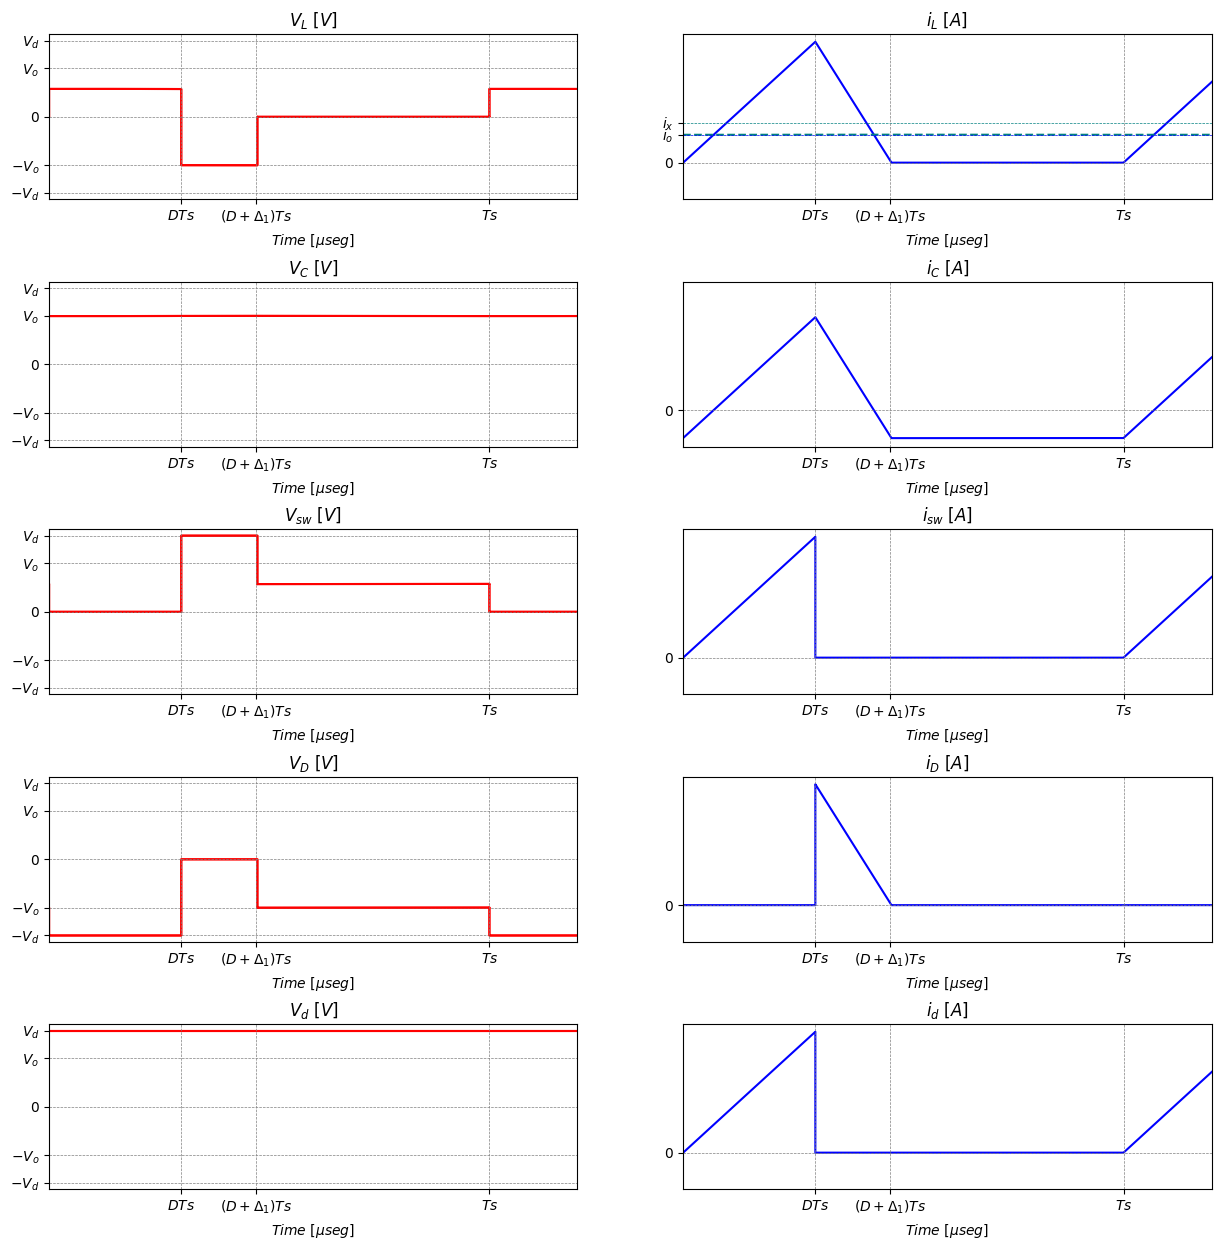

In [79]:
import ltspice
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Load the signals from the .raw file
raw_file = 'Buck_Ideal_DCM.raw'
l = ltspice.Ltspice(raw_file) 
# Make sure that the .raw file is located in the correct path
l.parse() 

#Parameters for the circuit
Vd_param = 12
Fs = 100E3
D = 0.3
Ts = 1/Fs
L = 40E-6
C = 15E-6
R = 100

def function_Vo(Vo_param):
    return (Vo_param/Vd_param -  D**2/(D**2 + 2*Vo_param*L/(Vd_param*Ts*R)))

Vo_param = fsolve(function_Vo, Vd_param/2)
Vo_param = Vo_param[0]
delta_1 = Vo_param*2*L/(Vd_param*D*Ts*R)
io_param = Vo_param/R
ix = io_param/(1-D)
#How many periods we want?
N_periods = 1.2

#Obtain basic signals

time = l.get_time()
time = (time - 1E-3)*1E+6                     #Convert to useg
Vd_plus = l.get_data('V(vd+)')
Vo = l.get_data('V(vo+)')
Vd = l.get_data('V(vd)')

#Obtener compound signals
Vl = Vd_plus - Vo
Vc = Vo
Vsw = Vd - Vd_plus
Vdiode = -Vd_plus

#Obtain currents
il = l.get_data('I(L1)')
ic = l.get_data('I(C1)')
isw = l.get_data('I(S1)')
io = l.get_data('I(R1)')
id = -l.get_data('I(V1)')
idiode = l.get_data('I(D1)')

signals = [Vl, il, Vc, ic, Vsw, isw, Vdiode, idiode, Vd, id]
num_signals = len(signals)
labels = ["$V_L$", "$i_L$", "$V_C$", "$i_C$", "$V_{sw}$", "$i_{sw}$", "$V_D$", "$i_D$", "$V_d$", "$i_d$"]

#Set max and min Voltages and currents
V_upper_limit = 13
V_lower_limit = -13
I_upper_limit = 0.35
I_lower_limit = -0.1

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
#Adjust spacing
fig.subplots_adjust(hspace=0.5)
for i, ax in enumerate(axs.flatten()):
    xticks_list = []
    xticks_labels = []
    yticks_list = []
    yticks_labels = []

    if i%2 == 0:    #Voltage signals are odd (0, 2, 4)
        ax.plot(time, signals[i], color = 'red')
        ax.set_title(labels[i] + " $ [V]$")

        yticks_list.append(Vd_param)
        yticks_list.append(Vo_param)
        yticks_list.append(-Vd_param)
        yticks_list.append(-Vo_param)
        
        yticks_labels.append("$V_d$")
        yticks_labels.append("$V_o$")
        yticks_labels.append("$-V_d$")
        yticks_labels.append("$-V_o$")

        ax.axhline(y= Vd_param, linestyle='--', linewidth = 0.5, color='grey')
        ax.axhline(y= Vo_param, linestyle='--', linewidth = 0.5,color='grey')
        ax.axhline(y= -Vd_param, linestyle='--', linewidth = 0.5,color='grey')
        ax.axhline(y= -Vo_param, linestyle='--', linewidth = 0.5,color='grey')
        ax.set_ylim(V_lower_limit, V_upper_limit)

        ax.plot(time, signals[i], color = 'red')
        
    else:
        ax.set_title(labels[i] + " $[A]$")
        ax.set_ylim(I_lower_limit, I_upper_limit)

        ax.plot(time, signals[i], color = 'blue')

    if labels[i] == "$i_L$":
        ax.plot(time, io, color = 'teal', linestyle='--')
        #Anotate and draw dashed lines for io and ix
        ax.axhline(y= ix, linestyle='--', linewidth = 0.5, color='teal')
        ax.axhline(y= io_param, linestyle='--', linewidth = 0.5, color='blue')

        yticks_list.append(ix)
        yticks_list.append(io_param)
        
        yticks_labels.append("$i_x$")
        yticks_labels.append("$i_o$")

    ax.set_xlabel("$Time\ [\mu seg]$")
    ax.grid(False)
    #Set the part we want to see
    ax.set_xlim(0, N_periods*Ts*1E6)
    
    #Draw vertical lines at the points of switching
    for i in range(int(N_periods)):
        ax.axvline(x=(D + i)*Ts*1E6, linestyle='--', linewidth = 0.5,color='grey')
        ax.axvline(x=(D + delta_1 + i)*Ts*1E6, linestyle='--', linewidth = 0.5,color='grey')
        ax.axvline(x=(1 + i)*Ts*1E6, linestyle='--', linewidth = 0.5,color='grey')    

        xticks_list.append((D*Ts + i*Ts)*1E6)
        xticks_list.append((D + delta_1 + i)*Ts*1E6)
        xticks_list.append((1 + i)*Ts*1E6)
        if i == 0:
            xticks_labels.append("$DTs$")
            xticks_labels.append("$(D+\Delta_1)Ts$")
            xticks_labels.append("$Ts$")
        else:
            xticks_labels.append("$(D" + "+" + str(i) + ")Ts$")
            xticks_labels.append("$(D+\Delta_1" + "+" + str(i) + ")Ts$")
            xticks_labels.append("$" + str(i+1) + "Ts$")

        #Agrego el 0
        ax.axhline(y= 0, linestyle='--', linewidth = 0.5, color='grey')
        yticks_list.append(0)
        yticks_labels.append("$0$")

    ax.set_xticks(xticks_list)
    ax.set_yticks(yticks_list)
    ax.set_xticklabels(xticks_labels)
    ax.set_yticklabels(yticks_labels)

    ax.yaxis.set_label_coords(-0.01, 0.9)

    
    
#axs[-1, -1].axis('off')  # Hide last subplot if there are an odd number of signals

# Add a legend
#ig.legend([f'Signal {i+1}' for i in range(num_signals)])

# Save the figure to a PDF file
plt.savefig('Buck_DCM_signals.pdf')